In [447]:
import wikipedia
wikipedia.set_lang('en') # setting wikipedia language
import wikipediaapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

import nltk # for nlp on articles
nltk.download("stopwords")
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucaseckes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaseckes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# I. Data Acquisition

## Data Acquisition Utils

In [ ]:
class DataAquisitionUtils():

    @staticmethod
    def fetch_category_members(category_members, level=0, max_level=1):
        """
        Function to take all article in category (max_level control the depth of articles taken from the subcategories)
        Arguments:
        category_members - a list of category members
        level - the level at which to start getting articles
        max_level - the maximal level for the fetched articles
        Returns:
        list_articles - a list of the desired articles
        """
#         return 0
        list_articles = []
        for c in categorymembers.values():
            if c.ns == 0:
                list_articles.append(c) 
                ##print("%s: %s (ns: %d)" % ("*" * (level + 1), c.title, c.ns))
            elif level < max_level and c.ns == 14:
                sub_list = []
                sub_list = print_categorymembers(c.categorymembers, level=level + 1, max_level=max_level)
                list_articles = list_articles + sub_list
        return list_articles

    @staticmethod
    def hyperlinks_matrix(list_articles):
        """
        Computes an adjacency matrix with the hyperlinks between the different articles in the argument given
        Arguments:
        list_articles - a list of articles for which to compute the hyperlink matrix
        Returns:
        matrix - a binary matrix A where A[i,j] = 1 if article i has a hyperlinkt to article j, and A[i,j] = 0 otherwise
        """
        matrix = np.zeros((len(list_articles), len(list_articles)))
        compt = 0
        for article in list_articles:
            if (compt%10 == 0) :
                print(compt)
            for link in article.links:
                for i in range(len(list_articles)):
                    if (link == list_articles[i].title):
                        matrix[compt,i] = 1
            compt = compt + 1
        return matrix
    
    @staticmethod
    def take_words(list_articles, stop_words, is_title = False):
        """
        Function that tokenizes and returns all words in the list of articles given
        Arguments:
        list_articles - list of articles
        is_title - whether the list contains pages or just strings of titles
        Returns:
        words_df - the words in the articles in a dataframe
        """
        words_df = pd.DataFrame(columns=['article', 'words'])
        for i in range(len(list_articles)):
            if (i%100 == 0) :
                print(i)
            try: 
                if (is_title == False):
                    page = wikipedia.page(list_articles[i].title)
                else:
                    page = wikipedia.page(list_articles[i])
            except wikipedia.DisambiguationError as e:
                s = e.options
                s = list(filter(lambda x : x != "", s))
                try :
                    page = wikipedia.page(s)
                except wikipedia.DisambiguationError as e:
                    pass
            except wikipedia.PageError:
                pass
            words = word_tokenize(page.content)
            words = [elem.lower() for elem in words]
            words = [elem for elem in words if len(elem) > 1 and elem.isalpha() == True]
            words_wostop = [x for x in words if x not in stop_words]
            words_wostop = [elem.lower() for elem in words_wostop]
            if (is_title == False):
                words_df.loc[i] = [list_articles[i].title] + [words_wostop]
            else:
                words_df.loc[i] = [list_articles[i]] + [words_wostop]
        return words_df
    
    @staticmethod
    def make_features(words, important_words_df):
        explode_df = words.explode('words')
        explode_df['exist'] = np.ones(len(explode_df))
        df = pd.DataFrame(words['article']).assign(key = 1).merge(pd.DataFrame(important_words_df['words']).assign(key = 1), on = 'key').drop('key', 1)
        df2 = df.merge(explode_df, on = ['article','words'] , how = 'left').drop_duplicates().fillna(0)
        df3 = pd.pivot_table(df2, values = 'exist',  index = 'article', columns=['words'])
        display(df3.head(10))
        features = df3.values
        return features

## NLP Utilities

In [ ]:
class NLPUtilities():
    
    @staticmethod
    def TF_IDF(words_df, nb_words):
        """
        Function to get the words with the top TF-IDF scores
        Arguments:
        words_df - the dataframe consisting of the words to be considered
        nb_words - the number of words we would like the function to return
        Returns:
        df - a dataframe containing the words with the best TF-IDF scores
        """
        #remove strings like "10,000"
        #religion_df['words'] = religion_df['words'].apply(lambda word_list: list(filter(lambda word: (',' not in word), word_list)))
        #only keep strings that contain alphabet chars
        words_df['words'] = words_df['words'].apply(lambda word_list: list(filter(lambda word: word.isalpha(), word_list)))
        # create a column with all words concatenated
        words_df['words_string'] = words_df['words'].apply(lambda words_list: " ".join(words_list))

        cv=CountVectorizer()
        word_count_vector=cv.fit_transform(words_df['words_string'])

        tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
        tfidf_transformer.fit(word_count_vector)

        # count matrix
        count_vector=cv.transform(words_df['words_string'])

        # tf-idf scores
        tf_idf_vector=tfidf_transformer.transform(count_vector)

        feature_names = cv.get_feature_names()

        #get tfidf vector for first document
        first_document_vector=tf_idf_vector[0]

        #print the scores
        df = pd.DataFrame(first_document_vector.T.todense(), index=feature_names, columns=["tfidf"])
        df = df.sort_values(by=["tfidf"],ascending=False).head(nb_words)
        return df

## Data Acquisition Pipeline

### Fetching the articles of interest

In [ ]:
aquire = DataAquisitionUtils()

In [3]:
wiki_wiki = wikipediaapi.Wikipedia('en') # getting articles in english
# fetching the articles for categories of interest
religion_page = wiki_wiki.page("Category:Religion")
science_page = wiki_wiki.page("Category:Science")

In [392]:
religion_articles = aquire.fetch_category_members(religion_page.categorymembers,0,1)
science_articles = aquire.fetch_category_members(science_page.categorymembers)

In [394]:
list_articles = religion_articles + science_articles
adjacency_matrix = aquire.hyperlinks_matrix(list_articles)
num_edges = np.count_nonzero(adjacency_matrix)
print(f"Number of edges in the feature graph: {num_edges}")

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650
1660
1670
1680
1690
1700
1710
1720
1730
1740
1750
1760
1770
1780
1790
1800
1810
1820
1830
1840
1850
1860
1870
1880
1890
1900
1910
1920
1930
1940
1950
1960
1970
1980
1990
2000
2010
2020
2030
2040
2050
2060
2070
2080
2090
2100
2110
2120
2130
2140
2150
2160
2170
2180
2190
2200
2210
2

NameError: name 'adjacency_matrix' is not defined

In [396]:
np.savetxt('hyperlinks.csv',hyperlink_matrix)

### Taking the words with the highest TF-IDF

In [6]:
#Take all the words present in the articles that are not stopwords
stop_found = ['====', '===', '==', '<<', '>>', "''", '``', "'s" , '\displaystyle', '...', '\phi', '\mu', '\mathbf', '--', 'x_',
        '\alpha', '\dot', '\hat', '\lambda', '\left', '\right', 'mathcal', '\nu', '\partial'] #getting the stopwords found in the articles after exmination
stop_pre = stopwords.words('english') # getting the common english stopwords
stop_words = stop_found + stop_pre

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lucaseckes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/lucaseckes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [7]:
religion_df = aquire.take_words(religion_articles, stop_words)

In [129]:
science_df = aquire.take_words(science_articles, stop_words)

0
10
20
30
40
50
60
70
80
90
100


/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/wikipedia/wikipedia.py:389: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("html.parser"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 389 of the file /Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/wikipedia/wikipedia.py. To get rid of this warning, pass the additional argument 'features="html.parser"' to the BeautifulSoup constructor.

  lis = BeautifulSoup(html).find_all('li')


110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490
500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500
1510
1520
1530
1540
1550
1560
1570
1580
1590
1600
1610
1620
1630
1640
1650


In [130]:
religion_labeled_df = religion_df.copy()
religion_labeled__df['label'] = 0

science_labeled_df = science_df.copy()
science_labeled_df['label'] = 1

words_df = pd.concat([religion_labeled_df, science_labeled_df])
labels_df = words_df['label']
words_df.drop(columns=['label'])

In [131]:
nlpu = NLPUtilities()

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [ ]:
TF_IDF_religion = nlpu.TF_IDF(religion_df, 500)
TF_IDF_science = nlpu.TF_IDF(science_df, 500)
important_words_df = pd.concat([TF_IDF_religion, TF_IDF_science])
important_words_df['words'] = important_words_df.index
important_words_df = important_words_df.drop_duplicates(subset = ['words'])
important_words_df.sort_values(['tfidf'], ascending = False)

In [450]:
features = aquire.make_features(words_df, important_words_df)

NameError: name 'aquire' is not defined

We have hence aquired the data and put it in a dataframe called features. Its rows are the different articles and each column is an important word (according to TF-IDF scores).

# II. Data Exploration

In [451]:
from scipy.spatial.distance import pdist, squareform
import operator
from sklearn.manifold import TSNE

## Matrix Utilities

In [463]:
class MatrixUtils():
    
    @staticmethod
    def epsilon_similarity_graph(X: np.ndarray, sigma=1, epsilon=0):
        """ 
        Fnction to compute the epsilon similarity graph seen in class
        Arguments:
        X (n x d): coordinates of the n data points in R^d.
        sigma (float): width of the kernel
        epsilon (float): threshold
        Returns:
        adjacency (n x n ndarray): adjacency matrix of the graph.
        """
        adjacency = squareform(pdist(X))
        adjacency = np.exp((- adjacency**2)/(2 * sigma**2))
        adjacency[adjacency < epsilon] = 0
        #according to the formula on slide 11 in the spectral clustering lecture, we set the diagonal to 0
        np.fill_diagonal(adjacency,0)
        return adjacency
    
    @staticmethod
    def compute_laplacian(adjacency: np.ndarray, normalize: bool):
        """ 
        Function to compute the laplacian
        Arguments:
        adjacency - an adjacency matrix for which to compute the laplacian
        normalize - if set to True, the normalized laplacian is returned, otherwise the combinatorial one is returned 
        Returns:
        L (n x n ndarray): combinatorial or symmetric normalized Laplacian.
        """
        degrees_l = np.sum(adjacency,axis=1)
        if(not normalize):
            degrees = np.zeros(adjacency.shape)
            np.fill_diagonal(degrees,degrees_l)
            return degrees - adjacency 
        else:
            degrees = np.sqrt(np.array([degrees_l]).T @ np.array([degrees_l]))
            L = - adjacency/degrees
            np.fill_diagonal(L,np.ones(len(adjacency)))
            return L
    
    @staticmethod
    def spectral_decomposition(laplacian: np.ndarray):
        """
        Function to carry out spectral decomposition on a given matrix
        Arguments:
        laplacian - matrix on which to carry out decomposition
        Returns:
        lamb (np.array): eigenvalues of the Laplacian
        U (np.ndarray): corresponding eigenvectors.
        """
        values, vectors = np.linalg.eig(laplacian)
        sorted_indices = np.argsort(values)
        return values[sorted_indices], vectors[:,sorted_indices]
    
    @staticmethod
    def GFT(signal: np.ndarray):
        """
        Function to compute the fourier transform of a signal
        Arguments:
        signal - the signal for which to compute the fourier transform (in the form of an Numpy array)
        Returns:
        fourier - the fourier transform of the signal provided
        """
        fourier = U.transpose()@signal
        return fourier
    
    @staticmethod
    def iGFT(fourier_coefficients: np.ndarray):
        """
        Function to compute the signal from a fourier transform
        Arguments:
        fourier_coefficients - the fourier coefficients from which to get the signal (in the form of an Numpy array)
        Returns:
        signal - the signal for the fourier coefficients given
        """
        signal = U@fourier_coefficients
        return signal

## Filter Utilities

In [464]:
class FilterUtilities():
    
    @staticmethod    
    def ideal_graph_filter(x: np.ndarray, spectral_response: np.ndarray):
        """
        Function to apply an idea filter to a graph
        Arguments:
        x - the signal on which to apply the filter
        spectral_response - the spectral response of the signal
        Returns:
        filtered_graph - a filtered signal
        """
        fourier = MatrixUtils().GFT(x);
        h = np.diag(spectral_response)
        filtered_graph = U@h@fourier
        return filtered_graph

In [465]:
class VisUtils():
    
    @staticmethod
    def laplacian_eigenmaps(X:np.ndarray, dim: int, sigma: float, epsilon: float, normalize: bool):
        """
        Function to compute the laplacian eigenmap if a given matrix
        Arguments:
        X - the matrix for which to compute the eigenmaps
        dim - the dimension of the data we would like to return
        sigma - the sigma parameter for the epsilon similarity graph
        epsilon - the epsilon parameter for the epsilon similarity graph
        normalize - if set to True, the normalized laplacian is used, otherwise the combinatorial one is used 
        Returns:
        coords (n x dim array): new coordinates for the data points
        """
        adjacency = MatrixUtils().epsilon_similarity_graph(X, sigma, epsilon)
        laplacian = MatrixUtils().compute_laplacian(adjacency, normalize)
        eigenvalues, eigenvectors = MatrixUtils().spectral_decomposition(np.nan_to_num(laplacian)) 
        return (eigenvectors[:,1:dim+1])

## Exploring graph properties

In [388]:
# computing the distances between the articles
distances = np.array([[(np.sum((features[i,:]-features[j,:])**2)) for i in range(0,features.shape[0]) ] for j in range(0,features.shape[0])]).reshape(features.shape[0],-1)

array([4.000e+00, 3.700e+01, 2.000e+00, 1.160e+02, 5.980e+02, 8.900e+01,
       1.073e+03, 5.600e+01, 5.400e+02, 3.130e+02, 3.590e+02, 3.950e+02,
       2.190e+02, 1.050e+02, 3.150e+02, 2.410e+02, 4.000e+00, 7.400e+01,
       2.160e+02, 9.000e+00, 1.400e+01, 2.440e+02, 2.390e+02, 5.000e+00,
       1.000e+01, 4.000e+00, 8.000e+00, 1.300e+01, 1.800e+01, 4.520e+02,
       2.102e+03, 4.000e+00, 7.000e+00, 9.860e+02, 8.400e+01, 1.072e+03,
       2.000e+00, 6.070e+02, 8.000e+00, 3.140e+02, 4.200e+01, 5.400e+01,
       5.200e+01, 1.620e+02, 1.480e+02, 1.000e+01, 1.100e+01, 8.100e+01,
       3.180e+02, 1.910e+02, 4.100e+02, 3.000e+02, 1.600e+01, 2.900e+02,
       3.140e+02, 4.670e+02, 8.660e+02, 3.640e+02, 1.700e+01, 1.400e+01,
       2.740e+02, 2.250e+02, 2.720e+02, 5.160e+02, 1.300e+02, 7.100e+02,
       6.900e+01, 1.570e+02, 4.510e+02, 3.490e+02, 3.900e+02, 4.630e+02,
       2.000e+00, 2.410e+02, 4.000e+00, 6.000e+00, 1.100e+02, 1.470e+02,
       1.400e+01, 1.142e+03, 1.100e+02, 8.190e+02, 

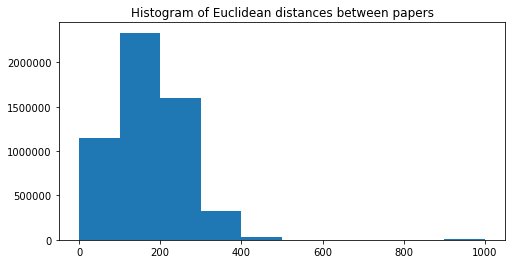

In [455]:
plt.figure(1, figsize=(8, 4))
plt.title("Histogram of Euclidean distances between papers")
plt.hist(distances.flatten());

In [459]:
feat = np.where(distances<150,1,0)
np.fill_diagonal(feat, 0)

In [460]:
# building a graph using the normalized distances
graph = nx.from_numpy_matrix(feat)

In [461]:
# assessing the giant component size
giant_feature = max(nx.connected_component_subgraphs(graph), key=len)
print('The giant component of the feature graph has {} nodes and {} edges.'.format(giant_feature.number_of_nodes(), giant_feature.size()))

The giant component of the feature graph has 1770 nodes and 1141851 edges.


In [ ]:
# getting the average clustering coefficient of our graph
nx.average_clustering(graph)

## Exploring possible clustering in the graph

In [472]:
matrixu = MatrixUtils()

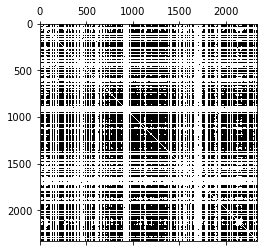

In [473]:
plt.spy(feat)
plt.show()

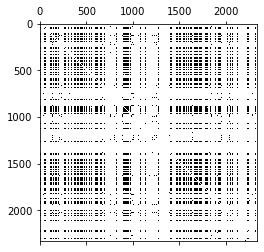

In [481]:
adjacency = matrixu.epsilon_similarity_graph(feat, sigma= 8*np.mean(feat), epsilon=0.40)
plt.spy(adjacency)
plt.show()

In [ ]:
import operator
pr = nx.pagerank(graph)
sorted_pr = sorted(pr.items(), key=operator.itemgetter(1), reverse = True)

In [ ]:
sorted_pr[:10]

## Exploring possible clustering in the graph after passing it through an ideal filter

In [300]:
# Computing the laplacian
laplacian = matrixu.compute_laplacian(adjacency, normalize=True)
lam, U = matrixu.spectral_decomposition(np.nan_to_num(laplacian))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


In [181]:
alpha = 0.99 / np.max(lam)

ideal_tk =  1/(1 + alpha*lam)

In [183]:
filt = ideal_graph_filter(adjacency.tolist(),ideal_tk)

In [184]:
graph_filt = nx.from_numpy_matrix(filt)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph, **options)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(graph_filt, **options)

In [ ]:
giant_features = max(nx.connected_component_subgraphs(graph_filt), key = len)

In [ ]:
options = {
    'node_color': 'black',
    'node_size': 20,
    'line_color': 'grey',
    'linewidths': 0.2,
    'width': 0.3,
}
nx.draw(giant_features, **options)

In [ ]:
giant_features.nodes

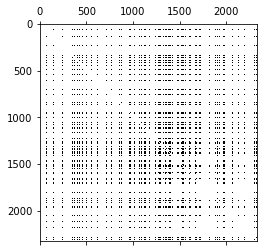

In [196]:
adjacency_filt = epsilon_similarity_graph(filt, sigma= 2*np.mean(feat), epsilon=0.60)
plt.spy(adjacency)
plt.show()

## Visualizing the graph obtained

In [ ]:
visu = VisUtils()

### Laplacian Eigenmaps

In [ ]:
twoD_embeddings = visu.laplacian_eigenmaps(feat, dim=2, sigma= 8*np.mean(feat), epsilon=0.40, normalize=True)

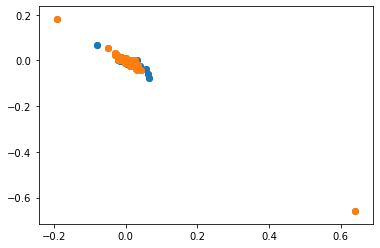

In [201]:
plt.scatter(twoD_embeddings[0:800,0], twoD_embeddings[0:800,1], label=1)
plt.scatter(twoD_embeddings[800:2650,0], twoD_embeddings[800:2650,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using Laplacian Eigenmaps)')

### t-sne

In [397]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2)
x_embed = tsne.fit_transform(adjacency)

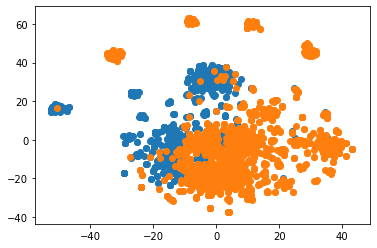

In [403]:
plt.scatter(x_embed[0:800,0], x_embed[0:800,1], label=1)
plt.scatter(x_embed[800:2650,0], x_embed[800:2650,1], label=2)
plt.title('Graph of Wikipedia Science and Religion articles (done using tSN-E)')

# III. Machine Learning

In [210]:
import time

import torch
import torch.nn as nn
import torch.nn.functional as F

from dgl import DGLGraph
import dgl.function as fn

np.random.seed(0)
torch.manual_seed(1)

In [211]:
class LaplacianPolynomial(nn.Module):
    def __init__(self,
                 in_feats: int,
                 out_feats: int,
                 k: int,
                 dropout_prob: float,
                 norm=True):
        super().__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self._k = k
        self._norm = norm
        # Contains the weights learned by the Laplacian polynomial
        self.pol_weights = nn.Parameter(torch.Tensor(self._k + 1))
        # Contains the weights learned by the logistic regression (without bias)
        self.logr_weights = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.dropout = nn.Dropout(p=dropout_prob)
        self.reset_parameters()

    def reset_parameters(self):
        """Reinitialize learnable parameters."""
        torch.manual_seed(0)
        torch.nn.init.xavier_uniform_(self.logr_weights, gain=0.01)
        torch.nn.init.normal_(self.pol_weights, mean=0.0, std=1e-3)

    def forward(self, graph, feat):
        r"""Compute graph convolution.

        Notes
        -----
        * Input shape: :math:`(N, *, \text{in_feats})` where * means any number of additional
          dimensions, :math:`N` is the number of nodes.
        * Output shape: :math:`(N, *, \text{out_feats})` where all but the last dimension are
          the same shape as the input.

        Parameters
        ----------
        graph (DGLGraph) : The graph.
        feat (torch.Tensor): The input feature

        Returns
        -------
        (torch.Tensor) The output feature
        """
        feat = self.dropout(feat)
        graph = graph.local_var()
        
        # D^(-1/2)
        norm = torch.pow(graph.in_degrees().float().clamp(min=1), -0.5)
        shp = norm.shape + (1,) * (feat.dim() - 1)
        norm = torch.reshape(norm, shp)

        # mult W first to reduce the feature size for aggregation.
        feat = torch.matmul(feat, self.logr_weights)

        result = self.pol_weights[0] * feat.clone()

        for i in range(1, self._k + 1):
            old_feat = feat.clone()
            if self._norm:
                feat = feat * norm
            graph.ndata['h'] = feat
            # Feat is not modified in place
            graph.update_all(fn.copy_src(src='h', out='m'),
                             fn.sum(msg='m', out='h'))
            if self._norm:
                graph.ndata['h'] = graph.ndata['h'] * norm

            feat = old_feat - graph.ndata['h']
            result += self.pol_weights[i] * feat

        return result

    def extra_repr(self):
        """Set the extra representation of the module,
        which will come into effect when printing the model.
        """
        summary = 'in={_in_feats}, out={_out_feats}'
        summary += ', normalization={_norm}'
        return summary.format(**self.__dict__)

In [212]:
def train(model, g, features, labels, loss_fcn, train_mask, optimizer):
    model.train()  # Activate dropout
    
    logits = model(g, features)
    loss = loss_fcn(logits[train_mask], labels[train_mask])

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss

def evaluate(model, g, features, labels, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask]  # only compute the evaluation set
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)
       
def test_articles(model, g, features, mask):
    model.eval()  # Deactivate dropout
    with torch.no_grad():
        logits = model(g, features)[mask] 
        _, indices = torch.max(logits, dim=1)
        return indices

In [372]:
from sklearn.model_selection import train_test_split
x1, x2, y1, y2, idx1, idx2 = train_test_split(
    feat, labels_df['label'], range(feat.shape[1]), test_size=0.4)
x3, x4, y3, y4, idx3, idx4 = train_test_split(
    x2, y2, idx2, test_size=0.5)

In [373]:
train_df = pd.DataFrame(np.column_stack((idx1, np.ones(len(idx1)).T)), columns = ['idx', 'indices'])
train_ = labels_df.merge(train_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
val_df = pd.DataFrame(np.column_stack((idx3, np.ones(len(idx3)).T)), columns = ['idx', 'indices'])
val_ = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)
test_df = pd.DataFrame(np.column_stack((idx4, np.ones(len(idx4)).T)), columns = ['idx', 'indices'])
test_ = labels_df.merge(val_df, left_index = True, right_on = 'idx', how = 'left').fillna(0)

In [374]:
features.shape

(2330, 1000)

In [375]:
in_feats = features.shape[1] 
n_classes = 2
pol_order = 3
lr = 0.2
weight_decay = 5e-6
n_epochs = 100
p_dropout = 0.8
features_ = torch.FloatTensor(features) 
labels = torch.LongTensor(labels_df['label']) 
train_mask = torch.BoolTensor(train_['indices'])
val_mask = torch.BoolTensor(val_['indices'])
test_mask = torch.BoolTensor(test_['indices'])

In [376]:
model = LaplacianPolynomial(in_feats, n_classes, pol_order, p_dropout)

graph = DGLGraph(graph)

loss_fcn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=lr,
                             weight_decay=weight_decay)

dur = []
for epoch in range(n_epochs):
    if epoch >= 3:
        t0 = time.time()
    loss = train(model, graph, features_, labels, loss_fcn, train_mask, optimizer)

    if epoch >= 3:
        dur.append(time.time() - t0)

    acc = evaluate(model, graph, features_, labels, val_mask)
    print("Epoch {:05d} | Time(s) {:.4f} | Train Loss {:.4f} | Val Accuracy {:.4f}". format(
            epoch, np.mean(dur), loss.item(), acc))

print()
acc = evaluate(model, graph, features_, labels, test_mask)
print("Test Accuracy {:.4f}".format(acc))

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Epoch 00000 | Time(s) nan | Train Loss 0.6932 | Val Accuracy 0.4641
Epoch 00001 | Time(s) nan | Train Loss 9.0115 | Val Accuracy 0.5067
Epoch 00002 | Time(s) nan | Train Loss 0.7495 | Val Accuracy 0.4529
Epoch 00003 | Time(s) 0.1711 | Train Loss 2.3036 | Val Accuracy 0.4529
Epoch 00004 | Time(s) 0.1706 | Train Loss 4.2787 | Val Accuracy 0.4507
Epoch 00005 | Time(s) 0.1715 | Train Loss 1.8527 | Val Accuracy 0.5471
Epoch 00006 | Time(s) 0.1731 | Train Loss 2.6986 | Val Accuracy 0.5717
Epoch 00007 | Time(s) 0.1736 | Train Loss 2.3006 | Val Accuracy 0.6031
Epoch 00008 | Time(s) 0.1728 | Train Loss 0.9401 | Val Accuracy 0.3767
Epoch 00009 | Time(s) 0.1722 | Train Loss 1.2846 | Val Accuracy 0.3430
Epoch 00010 | Time(s) 0.1721 | Train Loss 2.1541 | Val Accuracy 0.3430
Epoch 00011 | Time(s) 0.1724 | Train Loss 2.1861 | Val Accuracy 0.3430
Epoch 00012 | Time(s) 0.1723 | Train Loss 1.2641 | Val Accuracy 0.3744
Epoch 00013 | Time(s) 0.1725 | Train Loss 0.7236 | Val Accuracy 0.5919
Epoch 00014 | T

In [377]:
coeff_gcn =  model.pol_weights.data.numpy()
print(coeff_gcn)

[-0.11737417  0.05720133  0.05533382  0.05744279]


In [378]:
model

LaplacianPolynomial(
  in=1000, out=2, normalization=True
  (dropout): Dropout(p=0.8, inplace=False)
)

In [379]:
def polynomial_graph_filter_response(coeff: np.array, lam: np.ndarray):
    """ Return an array of the same shape as lam.
        response[i] is the spectral response at frequency lam[i]. """
    # Your code here
    V = np.vander(lam, len(coeff), increasing=True)
    return V@coeff

/Users/lucaseckes/miniconda2/envs/ntds_2019/lib/python3.7/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0, 0.5, 'Spectral response (db)')

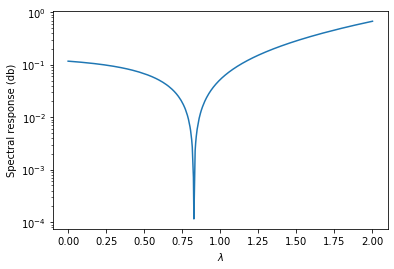

In [380]:
plt.semilogy(lam, np.abs(polynomial_graph_filter_response(coeff_gcn, lam)))
plt.xlabel('$\lambda$')
plt.ylabel('Spectral response (db)')

In [381]:
list_articles = ["God", "Network Science", "Jesus", "Quantic physics"]
test_df = take_words(list_articles, is_title = True)

0


In [382]:
test = make_features(test_df)
features_final = np.concatenate((features, test))

words,abhängigkeitsgefühl,aboriginal,abp,abrahamic,academic,accepts,according,achieving,across,acts,...,yazdânism,yazidi,yiguandao,zoroastrianism,zulu,émile,ānanda,đài,ōaṅkār,ƭat
article,,,,,,,,,,,,,,,,,,,,,
God,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
Jesus,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Network Science,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Quantic physics,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [383]:
distances = np.array([[(np.sum((features_final[i,:]-features_final[j,:])**2)) for i in range(0,features_final.shape[0]) ] for j in range(0,features_final.shape[0])]).reshape(features_final.shape[0],-1)
feat = distances/np.max(distances)
np.fill_diagonal(feat, 0)
graph = nx.from_numpy_array(feat)
graph = DGLGraph(graph)

In [386]:
features_ = torch.FloatTensor(features_final)

In [384]:
mask1 = np.zeros((len(features)))
mask2 = np.ones((len(test)))
mask = np.concatenate((mask1,mask2))
mask = torch.BoolTensor(mask)

In [387]:
test_articles(model, graph, features_, mask)

tensor([1, 1, 1, 1])

In [389]:
model.pol_weights

Parameter containing:
tensor([-0.1174,  0.0572,  0.0553,  0.0574], requires_grad=True)

In [390]:
model.logr_weights

Parameter containing:
tensor([[ 1.2907, -1.2909],
        [-1.0584,  1.0577],
        [ 0.0989, -0.0988],
        ...,
        [-0.2613,  0.2613],
        [-0.9524,  0.9525],
        [ 0.9983, -0.9981]], requires_grad=True)

In [85]:
len(mask)

2332